# Getting Started with Optuna, RAPIDS and Dask-Optuna for HPO
Hyperparameter optimization (HPO) automates the process of picking values for the hyperparameters of a machine learning algorithm to improve model performance. This can help boost the model accuracy greatly, but can be resource-intensive, as it may require training the model for hundreds of hyperparameter combinations. Let's take a look at how we can use Optuna and RAPIDS to make HPO less time-consuming.
## RAPIDS
The RAPIDS framework provides a suite of libraries to execute end-to-end data science pipelines entirely on GPUs. One of the libraries in this framework is cuML, which implements common machine learning models with a scikit-learn-compatible API and a GPU-accelerated backend. You can learn more about RAPIDS [here](https://rapids.ai/about.html).
## Optuna
[Optuna](https://optuna.readthedocs.io/en/stable/) is a lightweight framework for automatic hyperparameter optimization. It provides a define-by-run API, which makes it easy to adapt to any already existing code that we have and enables high modularity along with the flexibility to construct hyperparameter spaces dynamically. By simply wrapping the objective function with Optuna, we can perform a parallel-distributed HPO search over a search space as we'll see in this notebook.
## Dask-Optuna
[Dask-Optuna](https://jrbourbeau.github.io/dask-optuna/#) is a library to help integrate Optuna's distributed optimizations to run trials on a Dask Cluster. It provides a `dask_optuna.DaskStorage` that wraps the Optuna storage class. This class helps extend in-memory computations to workers in the cluster.
 
In this notebook, we'll use BNP Paribas Cardif Claims Management dataset from Kaggle to predict if a claim will receive accelerated approval or not. We'll explore how to use Optuna with RAPIDS in combination with Dask to run multi-GPU HPO experiments that can yield results faster than CPU.

In [1]:
# ## Run this cell to install optuna and dask_optuna
# !pip install optuna
# !pip install dask_optuna

# ## The plotting libraries
# !pip install plotly
# !pip install -U kaleido
# !pip install 'bokeh<2.0.0'

In [2]:
import random
import time
from contextlib import contextmanager

import cudf
import cuml
import dask_cudf
import numpy as np
import optuna
import pandas as pd
import sklearn
import os
import dask
import dask_optuna

from cuml import LogisticRegression
from cuml.dask.common import utils as dask_utils
from cuml.preprocessing.model_selection import train_test_split

from cuml.metrics import log_loss

from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait, performance_report

from joblib import parallel_backend, Parallel, delayed

In [3]:
# Helper function for timing blocks of code.
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print("..%-24s:  %8.4f" % (name, t1 - t0))

## Set up CUDA Cluster

We start a local cluster and keep it ready for running distributed tasks with dask. The dask scheduler can help leverage multiple nodes available on the cluster.

[LocalCUDACluster](https://github.com/rapidsai/dask-cuda) launches one Dask worker for each GPU in the current systems. It's developed as a part of the RAPIDS project. Learn More:
- [Setting up Dask](https://docs.dask.org/en/latest/setup.html)
- [Dask Client](https://distributed.dask.org/en/latest/client.html)

In [4]:
# This will use all GPUs on the local host by default
cluster = LocalCUDACluster(threads_per_worker=1, ip="", dashboard_address="8081")
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

Client Scheduler: tcp://172.17.0.2:35287 Dashboard: http://172.17.0.2:8081/status,Cluster Workers: 2 Cores: 2 Memory: 49.16 GB


# Loading the data
## Data Acquisition
Dataset can be acquired from Kaggle: [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/data). To download the dataset:
 
1. Create a `data` folder in the current directory. If you're downloading it elsewhere, be sure to change `data_dir` to point to the approproate location.
 
2. Follow the instructions here to: [Set-up the Kaggle API](https://github.com/Kaggle/kaggle-api)
 
3. Run the following command in the command line in the `data` folder.
 
    `kaggle competitions download -c bnp-paribas-cardif-claims-management`
 
 
This is an anonymized dataset containing categorical and numerical values for claims received by BNP Paribas Cardif.  The "target" column in the train set is the variable to predict. It is equal to 1 for claims suitable for an accelerated approval. The task is to predict whether a claim will be suitable for accelerated approval or not. We'll only use the `train.csv` file as `test.csv` does not have a target column.


In [5]:
import os

file_name = 'train.csv' 

data_dir = "data/"
INPUT_FILE = os.path.join(data_dir, file_name)

Select the `N_TRIALS` for the number of runs of HPO trials.

In [6]:
N_TRIALS = 150

df = cudf.read_csv(INPUT_FILE)

# Drop non-numerical data and fill NaNs before passing to cuML RF
CAT_COLS = list(df.select_dtypes('object').columns)
df = df.drop(CAT_COLS, axis=1)
df = df.fillna(0)

df = df.astype("float32")
X, y = df.drop(["target"], axis=1), df["target"].astype('int32')

study_name = "dask_optuna_lr_log_loss_tpe"
storage_name = "sqlite:///study_stores.db"

# Training and Evaluation

The `train_and_eval` function accepts the different parameters to try out. This function should look very similar to any ML workflow. We'll use this function within the Optuna `objective` function to show how easily we can fit an existing workflow into the Optuna work. 

In [8]:
def train_and_eval(X_param, y_param, penalty='l2', C=1.0, l1_ratio=None, fit_intercept=True):
    """
        Splits the given data into train and test split to train and evaluate the model
        for the params parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training
        penalty, C, l1_ratio, fit_intercept: The parameter values for Logistic Regression.

        Returns
        score: log loss of the fitted model
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X_param,
                                                          y_param,
                                                          random_state=42)
    classifier = LogisticRegression(penalty=penalty,
                                    C=C,
                                    l1_ratio=l1_ratio,
                                    fit_intercept=fit_intercept)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_valid)
    score = log_loss(y_valid, y_pred)
    return score

For a baseline number, let's see what the default performance of the model is.

In [9]:
print("Score with default parameters : ",train_and_eval(X, y))

[E] [19:22:04.506574] L-BFGS line search failed
Score with default parameters :  13.38012214622974


## Objective Function
 
The objective function will be the one we optimize in [Optuna Study](https://optuna.readthedocs.io/en/stable/reference/study.html). The objective function tries out specified values for the parameters that we are tuning and returns the score obtained with those parameters. These results will be aggregated in `study.trials_dataframes()`. 
 
Let's define the objective function for this HPO task by making use of the `train_and_eval()`. You can see that we simply choose a value for the parameters and call the `train_and_eval` method, making Optuna very easy to use in an existing workflow.
 
The objective function does not need to be changed when switching to different [samplers](https://optuna.readthedocs.io/en/stable/reference/samplers.html), which are built-in options in Optuna to enable the selection of different sampling algorithms that optuna provides. Some of the available ones include - GridSampler, RandomSampler, TPESampler, etc. We'll use TPESampler for this demo, but feel free to try different samplers to notice the changes in performance. 
 

[Tree-Structured Parzen Estimators](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler) or TPE works by fitting two  Gaussian Mixture Model during each trial - one to the set of parameter values associated with the best objective values,
and another to the remaining parameter values. It chooses the parameter value that maximizes the ratio between the two GMMs

In [10]:
def objective(trial, X_param, y_param):
    # Note that there are more parameters for RF, and tweaking those will
    # improve performance too. But for simplicity, we will use just
    # max_depth and n_estimators.

    # These are the recommended ranges for these parameters
    C = trial.suggest_uniform("C", 0 , 9.0)
    penalty = trial.suggest_categorical("penalty", ['l1', 'none', 'l2'])
    l1_ratio = trial.suggest_uniform("l1_ratio", 0 , 1.0)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty,
                           C=C,
                           l1_ratio=l1_ratio,
                           fit_intercept=fit_intercept)
    return score

## HPO Trials and Study
 
Optuna uses [study](https://optuna.readthedocs.io/en/stable/reference/study.html) and [trials](https://optuna.readthedocs.io/en/stable/reference/trial.html) to keep track of the HPO experiments. Put simply, a trial is a single call of the objective function while a set of trials make up a study. We will pick the best observed trial from a study to get the best parameters that were used in that run.

Here, dask_optuna Storage class is used to set up a storage shared by all workers in the cluster. Optuna also requires the use of a storage to run distributed optimization runs. Learn more about what storages can be used [here](https://optuna.readthedocs.io/en/stable/tutorial/distributed.html)

`optuna.create_study` is used to set up the study. As you can see, it specifies the study name, sampler to be used, the direction of the study, and the storage.
With just a few lines of code, we have set up a distributed HPO experiment.

In [11]:
with timed("dask_optuna"):
    # Create a study using Dask-compatible storage
    storage = dask_optuna.DaskStorage(storage_name)
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(),
                                study_name=study_name,
                                direction="minimize",
                                storage=storage)
    # Optimize in parallel on your Dask cluster
    with parallel_backend("dask"):
        study.optimize(lambda trial: objective(trial, X, y),
                           n_trials=N_TRIALS,
                           n_jobs=n_workers)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
study.best_trial

[I 2020-11-02 19:22:07,683] A new study created in RDB with name: dask_optuna_lr_log_loss_tpe


..dask_optuna             :   36.8001
Number of finished trials:  150
Best trial:


FrozenTrial(number=74, value=8.267213861082675, datetime_start=datetime.datetime(2020, 11, 2, 19, 22, 25, 764533), datetime_complete=datetime.datetime(2020, 11, 2, 19, 22, 26, 140160), params={'C': 1.5079138760466302, 'penalty': 'l2', 'l1_ratio': 0.3676214620667736, 'fit_intercept': False}, distributions={'C': UniformDistribution(high=9.0, low=0), 'penalty': CategoricalDistribution(choices=('l1', 'none', 'l2')), 'l1_ratio': UniformDistribution(high=1.0, low=0), 'fit_intercept': CategoricalDistribution(choices=(True, False))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=75, state=TrialState.COMPLETE)

## Visualization

Optuna provides an easy way to visualize the trials by integrating some graphs with the library. Here we will explore a few of them to see how our study did.

Read more about visualizations [here](https://optuna.readthedocs.io/en/stable/reference/visualization.html)

In [12]:
from IPython.display import Image

Let's look at the importance of each parameter to the performance of the model. This illustrates the impact that the hyperparameters have on the accuracy. We can see that `penalty` was most useful in this example.

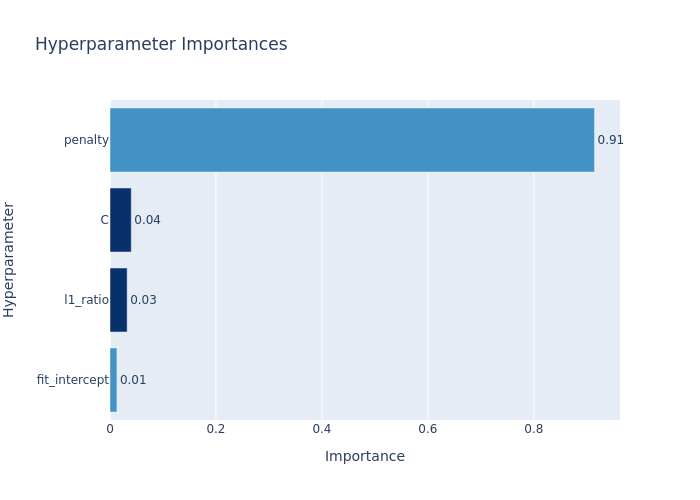

In [13]:
f = optuna.visualization.plot_param_importances(study)
Image(f.to_image(format="png", engine='kaleido'))

Let's look at how the optimisation within the study progressed with the history plot for the study.

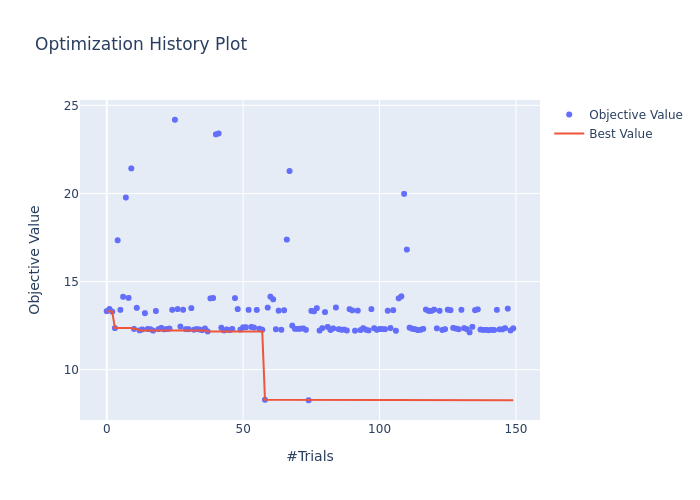

In [14]:
f = optuna.visualization.plot_optimization_history(study)
Image(f.to_image(format="png", engine='kaleido'))

The following is a parallel coordinate plot to understand the relationships between the parameters.

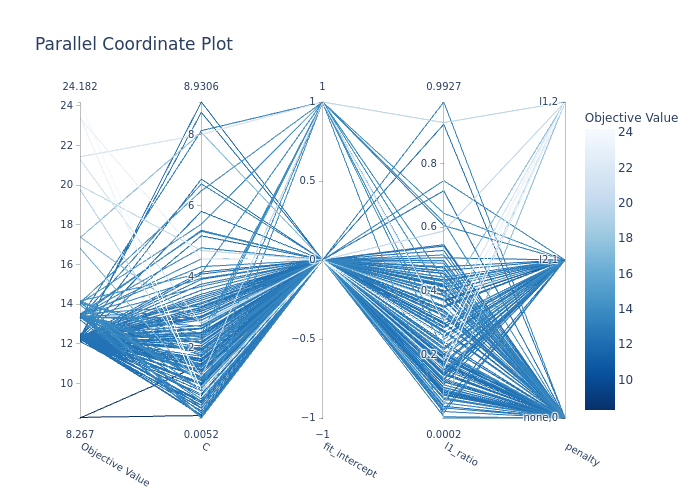

In [15]:
f = optuna.visualization.plot_parallel_coordinate(study, params=['C', 'l1_ratio', 'penalty', 'fit_intercept'])
Image(f.to_image(format="png", engine='kaleido'))

## Optuna Dashboard

Optuna provides dashboard to visualise the results. You can read more about it [here](https://optuna.readthedocs.io/en/stable/reference/cli.html)

To visualize the optuna dashboard run `optuna dashboard --study-name {study_name} --storage "{storage_name}"`. We will use the `-o` option to save the dashboard to a html file.

For this experiement run the following command:

In [16]:
print("Run the following to download the dashboard to dashboard.html: \n\n\t"
      f"optuna dashboard --study-name {study_name} --storage '{storage_name}' -o dashboard.html")

Run the following to download the dashboard to dashboard.html: 

	optuna dashboard --study-name dask_optuna_lr_log_loss_tpe --storage 'sqlite:///study_stores.db' -o dashboard.html


## Conluding Remarks
 
This notebook shows how RAPIDS and Optuna can be used along with dask to run multi-GPU HPO jobs, and can be used as a starting point for anyone wanting to get started with the framework. It also provides some visualization tools to interpret the results. We have seen how by just adding a few lines of code we were able to integrate the libraries for a muli-GPU HPO runs. This can also be scaled to multiple nodes.
 
## Next Steps
 
This is done on a small dataset, you are encouraged to test out on larger data with more range for the parameters too. These experiments can yield performance improvements. Refer to other examples in the [rapidsai/cloud-ml-examples](https://github.com/rapidsai/cloud-ml-examples) repository.
 
## Resources
[Hyperparameter Tuning in Python](https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624)

[Overview of Hyperparameter tuning](https://cloud.google.com/ai-platform/training/docs/hyperparameter-tuning-overview)

[How to make your model awesome with Optuna](https://towardsdatascience.com/how-to-make-your-model-awesome-with-optuna-b56d490368af)